In [56]:
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [57]:
price_df = pd.read_csv("data/processed/raw_prices.csv", index_col=0).astype(np.float32)
return_df = pd.read_csv("data/processed/returns_log.csv", index_col=0).astype(np.float32)

print("raw_prices shape:", price_df.shape)
print("returns_log shape:", return_df.shape)

print("raw_prices.columns:", price_df.columns.tolist())
print("returns_log.columns:", return_df.columns.tolist())

raw_prices shape: (667, 11)
returns_log shape: (667, 11)
raw_prices.columns: ['AAPL', 'AMZN', 'GOOGL', 'INTC', 'META', 'MSFT', 'NFLX', 'NVDA', 'TSLA', 'XOM', 'SPY']
returns_log.columns: ['AAPL', 'AMZN', 'GOOGL', 'INTC', 'META', 'MSFT', 'NFLX', 'NVDA', 'TSLA', 'XOM', 'SPY']


### buy and hold strategy

In [58]:
evaluation_periods = {
    "Period 1": ["2019-09-25", "2019-10-17"],
    "Period 2": ["2019-10-18", "2019-11-21"],
    "Period 3": ["2019-11-22", "2019-12-19"],
    "Period 4": ["2019-12-20", "2020-01-16"],
    "Period 5": ["2020-01-17", "2020-02-20"],
    "Period 6": ["2020-02-21", "2020-03-19"],
    "Period 7": ["2020-03-20", "2020-04-16"],
    "Period 8": ["2020-04-17", "2020-05-20"],
}

In [59]:
# Função para calcular retorno Buy and Hold
def compute_buy_and_hold_returns(price_df, periods_dict):
    results = {}
    for period_name, (start_date, end_date) in periods_dict.items():
        start_prices = price_df.loc[start_date]
        end_prices = price_df.loc[end_date]
        returns = ((end_prices - start_prices) / start_prices) * 100
        results[period_name] = returns
    return pd.DataFrame(results).T  # Transpõe para ficar com períodos nas linhas

# Aplica a função ao DataFrame de preços
buy_hold_df = compute_buy_and_hold_returns(price_df, evaluation_periods)

# Resultado
print(buy_hold_df)

               AAPL       AMZN      GOOGL       INTC       META       MSFT  \
Period 1   6.447097   1.082948   0.550585   1.646427   4.152097   0.236812   
Period 2  11.161374  -1.297298   4.478424  13.980558   6.499855   9.154059   
Period 3   6.967640   2.667089   4.852062   0.607546   3.641470   4.091212   
Period 4  12.811327   5.118395   7.322297   1.204396   7.498787   5.565086   
Period 5   0.731072  15.465055   2.532579  10.356212  -3.403259  10.666508   
Period 6 -21.808014 -10.259687 -25.062359 -28.598064 -27.143393 -20.090729   
Period 7  25.061092  30.448141  17.713743  32.642345  17.711882  28.896978   
Period 8  13.187468   5.176424  10.176698   5.129935  28.302837   4.242497   

               NFLX       NVDA       TSLA        XOM        SPY  
Period 1  10.802646   9.010850  14.547439  -4.498919   0.557763  
Period 2  13.218313  10.336500  38.093014   4.289618   4.127924  
Period 3   7.002058  11.733033  21.318760   0.028837   3.196545  
Period 4   0.510538   3.993817  2

In [60]:
# Ticker e intervalo de datas
ticker = "^GSPC"  # ou "SPY"
start_date = "2019-09-20"
end_date = "2020-05-21"

# Download dos dados
df = yf.download(ticker, start=start_date, end=end_date)

# Cálculo dos retornos diários com base na coluna Close
df['daily_return'] = df['Close'].pct_change() * 100  # em porcentagem

# Remove o primeiro valor (NaN)
df_returns = df[['daily_return']].dropna().reset_index()

# Renomeia colunas para clareza
df_returns.rename(columns={'Date': 'date', 'daily_return': 'sp500_daily_return_pct'}, inplace=True)

# Garante que a coluna 'date' é datetime
df_returns['date'] = pd.to_datetime(df_returns['date'])

# Lista para armazenar resultados
period_returns = []

# Loop pelos períodos
for period_name, (start, end) in evaluation_periods.items():
    mask = (df_returns['date'] >= start) & (df_returns['date'] <= end)
    period_data = df_returns.loc[mask, 'sp500_daily_return_pct']
    
    if not period_data.empty:
        cumulative_return = (1 + period_data / 100).prod() - 1  # retorno acumulado
        period_returns.append({
            "period": period_name,
            "start_date": start,
            "end_date": end,
            "sp500_period_return_pct": cumulative_return * 100  # em percentual
        })

# Cria o DataFrame final
df_period_returns = pd.DataFrame(period_returns)

# Garante que df_period_returns está com o índice correto e renomeado
df_sp500 = df_period_returns.set_index("period")[['sp500_period_return_pct']]
df_sp500.rename(columns={'sp500_period_return_pct': 'S&P500'}, inplace=True)

# Adiciona a coluna 'S&P500' ao buy_hold_df
buy_hold_df['S&P500'] = df_sp500['S&P500']

# Pronto!
print(buy_hold_df.head())


[*********************100%***********************]  1 of 1 completed

               AAPL       AMZN     GOOGL       INTC      META       MSFT  \
Period 1   6.447097   1.082948  0.550585   1.646427  4.152097   0.236812   
Period 2  11.161374  -1.297298  4.478424  13.980558  6.499855   9.154059   
Period 3   6.967640   2.667089  4.852062   0.607546  3.641470   4.091212   
Period 4  12.811327   5.118395  7.322297   1.204396  7.498787   5.565086   
Period 5   0.731072  15.465055  2.532579  10.356212 -3.403259  10.666508   

               NFLX       NVDA       TSLA        XOM       SPY    S&P500  
Period 1  10.802646   9.010850  14.547439  -4.498919  0.557763  1.056760  
Period 2  13.218313  10.336500  38.093014   4.289618  4.127924  3.522076  
Period 3   7.002058  11.733033  21.318760   0.028837  3.196545  3.281094  
Period 4   0.510538   3.993817  26.603218  -1.601365  3.177149  3.476664  
Period 5  13.639705  23.836679  76.182175 -11.436148  1.506246  1.701030  


In [61]:
agent_df = pd.read_csv("evaluation_outputs/position_value_series.csv", index_col=0).astype(np.float32)


In [62]:
# Supondo que agent_df já tem o índice como datetime
agent_df.index = pd.to_datetime(agent_df.index)

# Renomeia as colunas
agent_df.columns = ['AAPL', 'AMZN', 'GOOGL', 'INTC', 'META', 
                    'MSFT', 'NFLX', 'NVDA', 'TSLA', 'XOM', 'SPY']

returns = {}

for period_name, (start_date, end_date) in evaluation_periods.items():
    try:
        period_df = agent_df.loc[start_date:end_date]
        period_returns = {}

        for col in agent_df.columns:
            series = period_df[col]

            # Encontra o primeiro valor não-zero (ignora 0.0)
            non_zero = series[series != 0]

            if non_zero.empty:
                # Ativo não teve alocação durante o período
                period_returns[col] = np.nan
            else:
                initial = non_zero.iloc[0]
                final = series.iloc[-1]
                period_returns[col] = round((final - initial) / initial, 4)

        returns[period_name] = period_returns

    except Exception as e:
        print(f"⚠️ Erro ao processar {period_name}: {e}")
        continue

# Concatena os resultados
returns_df = pd.DataFrame(returns).T  # transposto para ficar com períodos nas linhas
returns_df.index.name = "Period"

# Exibe ou salva
print(returns_df)
# returns_df.to_csv("evaluation_returns.csv")


            AAPL    AMZN   GOOGL    INTC    META    MSFT    NFLX    NVDA  \
Period                                                                     
Period 1  9.7522  8.2674  4.2664  2.0192  8.8139  5.0285  8.8653  0.1228   
Period 2  1.0009  1.3689  1.4378  2.7994  0.2780  1.5469  1.3776  6.1719   
Period 3  0.6045  0.3963  0.4979  0.6463  0.9001  0.4573  0.5078  0.6760   
Period 4  0.4907  0.3604  0.2879  0.1186  0.2216  0.4075  0.3192  0.2875   
Period 5  0.1929  0.4500  0.1074  0.3042  0.3524  0.4883  0.2950  0.4218   
Period 6 -0.1486  0.0159  0.0269 -0.0215 -0.0488 -0.1210  0.0309 -0.1818   
Period 7  0.5007  0.4349  0.2726  0.6132  0.2262  0.4322  0.4313  0.7597   
Period 8  0.3174  0.2244  0.2119  0.2849  0.4925  0.2509  0.1887  0.5700   

            TSLA     XOM     SPY  
Period                            
Period 1  3.3504  4.7901  8.0502  
Period 2  2.7976  1.9201  1.6032  
Period 3  1.3051  0.5338  0.4289  
Period 4  0.5992  0.3262  0.2549  
Period 5  1.3256  0.1713  0.0

In [63]:
portfolio_df = pd.read_csv("evaluation_outputs/portfolio_total_series.csv", index_col=0).astype(np.float32)

In [64]:
initial_value = 1_000_000

portfolio_df.index = pd.to_datetime(portfolio_df.index)

# Define o valor inicial como 1.000.000 no dia anterior
initial_value = 1_000_000

# Calcula o retorno percentual em relação ao valor inicial
portfolio_df['portfolio_daily_return_pct'] = (portfolio_df['portfolio_total'] / initial_value - 1) * 100

# Visualiza resultado
print(portfolio_df[['portfolio_daily_return_pct']].head())

            portfolio_daily_return_pct
date                                  
2019-09-25                  -50.030603
2019-09-26                  -50.096122
2019-09-27                  -50.079128
2019-09-30                  -50.081212
2019-10-01                  -50.103322


[*********************100%***********************]  1 of 1 completed

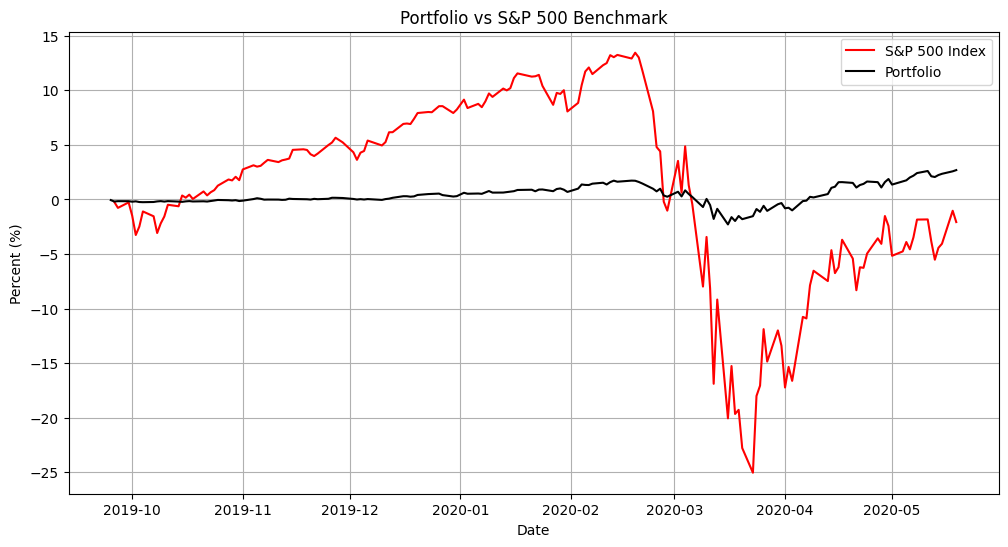

In [65]:
# --- 1. Benchmark: S&P 500 ---
benchmark_ticker = "^GSPC"
start_date = "2019-09-25"
end_date = "2020-05-20"

benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)
benchmark_data['Return'] = benchmark_data['Close'].pct_change()
benchmark_data['Cumulative Return'] = (1 + benchmark_data['Return']).cumprod() - 1
benchmark_data['Cumulative Return'] *= 100  # em porcentagem

# --- 2. Portfólio ---
# Supondo que portfolio_df tem índice datetime e coluna 'portfolio_total'
initial_value = 500000
portfolio_df['Cumulative Return'] = (portfolio_df['portfolio_total'] / initial_value - 1) * 100

# Alinha as datas (opcional, dependendo da frequência de dados)
common_dates = benchmark_data.index.intersection(portfolio_df.index)

# --- 3. Gráfico ---
plt.figure(figsize=(12,6))
plt.plot(benchmark_data.loc[common_dates].index,
         benchmark_data.loc[common_dates, 'Cumulative Return'],
         label='S&P 500 Index', color='red')

plt.plot(portfolio_df.loc[common_dates].index,
         portfolio_df.loc[common_dates, 'Cumulative Return'],
         label='Portfolio', color='black')

plt.ylabel("Percent (%)")
plt.xlabel("Date")
plt.title("Portfolio vs S&P 500 Benchmark")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
# Constrói a tabela de retornos por período
period_returns = {}
for period, (start_date, end_date) in evaluation_periods.items():
    mask = (portfolio_df.index >= start_date) & (portfolio_df.index <= end_date)
    period_data = portfolio_df.loc[mask, 'portfolio_daily_return_pct']
    
    if not period_data.empty:
        # Converte para fator de retorno e calcula acumulado
        cumulative_return = (1 + period_data / 100).prod() - 1
        period_returns[period] = cumulative_return * 100  # em %

# Cria o DataFrame com índice = período e coluna renomeada
portfolio_period = pd.DataFrame.from_dict(period_returns, orient='index', columns=['Portfolio'])

returns_df["Portfolio"] = portfolio_period["Portfolio"]


In [67]:
print(returns_df)
print(buy_hold_df)

            AAPL    AMZN   GOOGL    INTC    META    MSFT    NFLX    NVDA  \
Period                                                                     
Period 1  9.7522  8.2674  4.2664  2.0192  8.8139  5.0285  8.8653  0.1228   
Period 2  1.0009  1.3689  1.4378  2.7994  0.2780  1.5469  1.3776  6.1719   
Period 3  0.6045  0.3963  0.4979  0.6463  0.9001  0.4573  0.5078  0.6760   
Period 4  0.4907  0.3604  0.2879  0.1186  0.2216  0.4075  0.3192  0.2875   
Period 5  0.1929  0.4500  0.1074  0.3042  0.3524  0.4883  0.2950  0.4218   
Period 6 -0.1486  0.0159  0.0269 -0.0215 -0.0488 -0.1210  0.0309 -0.1818   
Period 7  0.5007  0.4349  0.2726  0.6132  0.2262  0.4322  0.4313  0.7597   
Period 8  0.3174  0.2244  0.2119  0.2849  0.4925  0.2509  0.1887  0.5700   

            TSLA     XOM     SPY  Portfolio  
Period                                       
Period 1  3.3504  4.7901  8.0502 -99.999260  
Period 2  2.7976  1.9201  1.6032 -99.999997  
Period 3  1.3051  0.5338  0.4289 -99.999806  
Period 4 

In [68]:
def save_table_plotly(df, filename, title=""):
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=["Period"] + list(df.columns),
            fill_color='#d3d3d3',  # cinza claro no cabeçalho
            align='center',
            font=dict(size=12, color='black')
        ),
        cells=dict(
            values=[[i for i in df.index]] + [
                df[col].map(lambda x: f"{x:.2f}%").tolist() for col in df.columns
            ],
            fill_color='#f5f5f5',  # fundo da tabela
            align='center',
            font=dict(size=11, color='black')
        )
    )])

    fig.update_layout(
        width=1200,  # largura maior
        height=200 + len(df),  # altura adaptativa
        title=dict(
            text=title,
            x=0.5,
            xanchor='center',
            font=dict(size=16, family='Arial')
        ),
        margin=dict(l=20, r=20, t=60, b=20)
    )

    fig.write_image(filename, format='png', scale=2)

save_table_plotly(returns_df, "evaluation_outputs/portfolio_table.png", "Retornos por Período - Estratégia MARL")
save_table_plotly(buy_hold_df, "evaluation_outputs/buy_hold_table.png", "Retornos por Período - Estratégia Buy & Hold")



In [76]:
period_table = pd.DataFrame([
    {"Period": k, "Date Range": f"{v[0]} to {v[1]}"}
    for k, v in evaluation_periods.items()
])

def save_period_table_plotly(period_df, filename):
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(period_df.columns),
            fill_color='#d3d3d3',
            align='center',
            font=dict(size=12, color='black')
        ),
        cells=dict(
            values=[period_df[col].tolist() for col in period_df.columns],
            fill_color='#f5f5f5',
            align='center',
            font=dict(size=11, color='black')
        )
    )])

    fig.update_layout(
        width=600,
        height=225 + len(period_df),  # altura proporcional às linhas
        margin=dict(l=20, r=20, t=20, b=20)
    )

    fig.write_image(filename, format='png', scale=2)

# Exemplo de chamada
save_period_table_plotly(period_table, "evaluation_outputs/period_table.png")
